# Generative Adversarial Networks (GANs)

## Introduction
Generative Adversarial Networks (GANs) are deep learning models used for generating new data instances similar to a given dataset. They consist of two neural networks, a generator and a discriminator, which are trained simultaneously in a competitive setting.

Generative Adversarial Networks (GANs) offer a unique approach to generative modeling, characterized by a competitive interplay between two neural networks: the generator and the discriminator. This diagram illustrates the fundamental concept of GANs:

![Generative Adversarial Network](https://i.imgur.com/6NMdO9u.png)

In this setup, the generator aims to produce synthetic data samples that are indistinguishable from genuine data, while the discriminator's objective is to accurately distinguish between real and fake data. Through an adversarial training process, both networks iteratively improve, leading to the generation of high-quality synthetic data.

# Example

Explore the intriguing capabilities of generative models by visiting [thispersondoesnotexist.com](https://thispersondoesnotexist.com). With each page reload, a novel image of a person's face is dynamically generated. The outcomes are captivating, showcasing the remarkable potential of generative models to produce realistic and diverse images.

![Generated Faces](https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png)



## Setup
Install Required Packages: The code begins by installing the `opendatasets` package using pip to facilitate dataset downloading.

In [1]:
!pip install opendatasets --upgrade --quiet

## Dataset Download
The Pokémon images and types dataset is downloaded using the `od.download` function from the `opendatasets` library. The dataset URL is specified as `dataset_url`.


In [2]:
import opendatasets as od

dataset_url = "https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types?select=images"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nitinjoshi07
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types


100%|██████████| 3.68M/3.68M [00:00<00:00, 161MB/s]

In [3]:
import os

DATA_DIR = '/content/pokemon-images-and-types'
print(os.listdir(DATA_DIR))

['images', 'pokemon.csv']


In [4]:
print(os.listdir(DATA_DIR+'/images')[:10])

['doublade.png', 'heatmor.png', 'buzzwole.png', 'turtwig.png', 'prinplup.png', 'ampharos.png', 'swinub.png', 'rapidash.png', 'turtonator.png', 'scyther.png']


## Import Necessary Libraries:

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

## Data Transformation:

The `torchvision.transforms` module is used to define a series of transformations to be applied to each image in the dataset. These transformations include resizing, center cropping, converting to tensor, and normalization.
   

In [45]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

## Create DataLoader:

The ImageFolder class from torchvision.datasets is used to create a dataset from the directory containing images. This dataset is then wrapped in a DataLoader

In [46]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [47]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [48]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

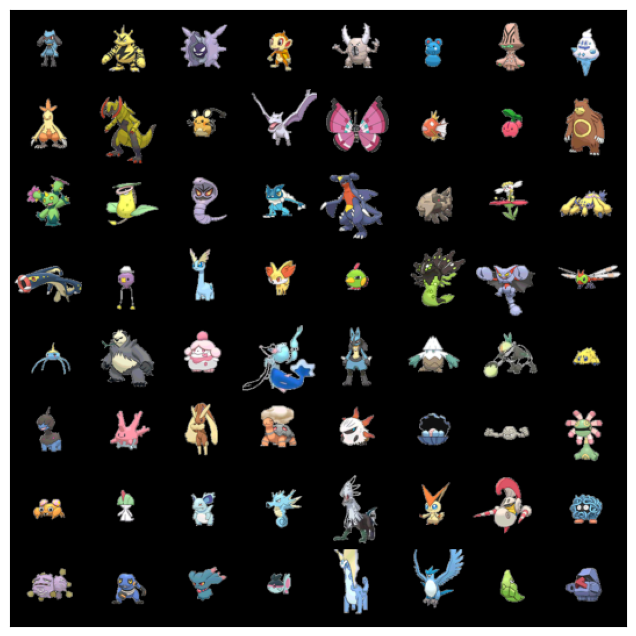

In [49]:
show_batch(train_dl)

In [50]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Device Selection:

The default device (GPU if available, else CPU) is selected using the get_default_device function.

In [51]:
device = get_default_device()
device

device(type='cuda')

## Data Loader Wrapper:
The DeviceDataLoader class is defined to wrap the data loader and move the data to the selected device.

In [52]:
train_dl = DeviceDataLoader(train_dl, device)

In [53]:
import torch.nn as nn

## Discriminator Model:
The discriminator model is defined as a sequence of convolutional layers followed by batch normalization and LeakyReLU activation functions.

In [54]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [55]:
discriminator = to_device(discriminator, device)

## Model Definition
Generator Model: The generator model is defined as a sequence of convolutional transpose layers followed by batch normalization and ReLU activation functions.

In [56]:
latent_size = 128

In [57]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([64, 3, 64, 64])


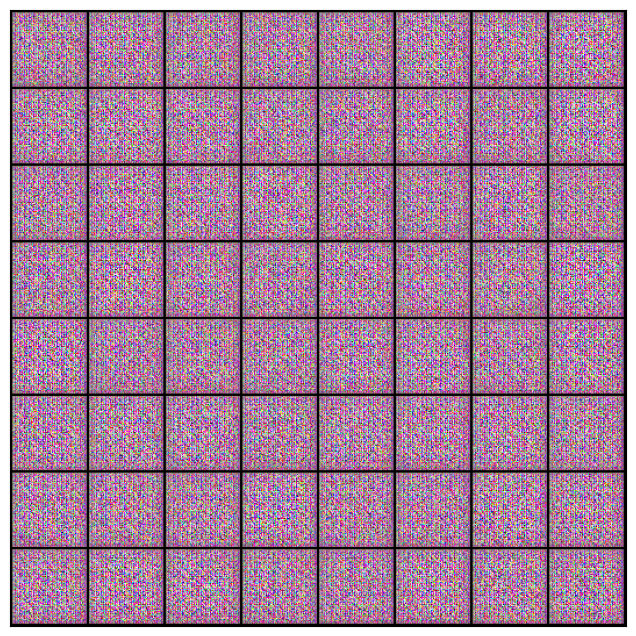

In [58]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [59]:
generator = to_device(generator, device)

## Training Functions:

Functions for training the discriminator and generator are defined.

In [60]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [61]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [62]:
from torchvision.utils import save_image

In [63]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [64]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [65]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


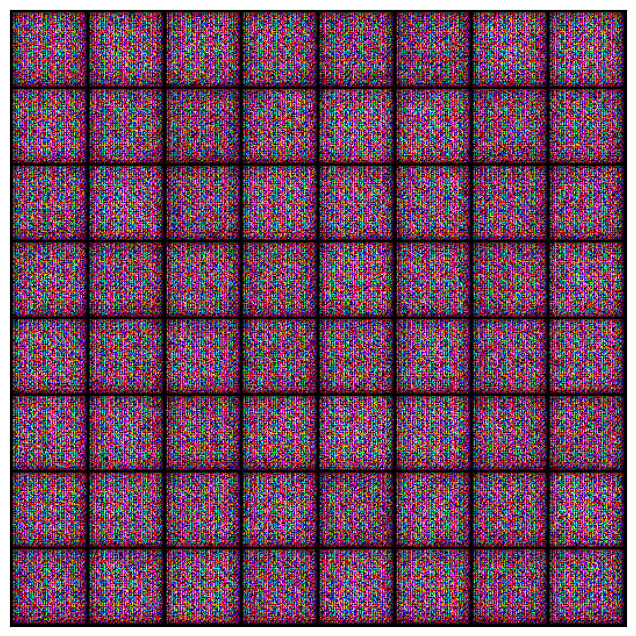

In [66]:
save_samples(0, fixed_latent)

In [67]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [68]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

## Training Loop:

The training loop is implemented using the fit function, which trains the discriminator and generator alternately for the specified number of epochs.

In [69]:
lr = 0.0002
epochs = 100

In [70]:
history = fit(epochs, lr)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 6.2532, loss_d: 0.0970, real_score: 0.9636, fake_score: 0.0460
Saving generated-images-0001.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 7.3715, loss_d: 0.0223, real_score: 0.9964, fake_score: 0.0185
Saving generated-images-0002.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 8.2079, loss_d: 0.0161, real_score: 0.9969, fake_score: 0.0129
Saving generated-images-0003.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 8.2945, loss_d: 0.0110, real_score: 0.9954, fake_score: 0.0064
Saving generated-images-0004.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 8.9107, loss_d: 0.0111, real_score: 0.9995, fake_score: 0.0105
Saving generated-images-0005.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 8.2038, loss_d: 0.0062, real_score: 0.9967, fake_score: 0.0029
Saving generated-images-0006.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 9.9857, loss_d: 0.0163, real_score: 0.9934, fake_score: 0.0096
Saving generated-images-0007.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 18.4484, loss_d: 0.5955, real_score: 0.9761, fake_score: 0.4009
Saving generated-images-0008.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 5.5519, loss_d: 0.2002, real_score: 0.9176, fake_score: 0.1035
Saving generated-images-0009.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 2.3003, loss_d: 0.4204, real_score: 0.8855, fake_score: 0.2429
Saving generated-images-0010.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 1.0402, loss_d: 0.4460, real_score: 0.8538, fake_score: 0.2111
Saving generated-images-0011.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 2.8719, loss_d: 0.4149, real_score: 0.7239, fake_score: 0.0661
Saving generated-images-0012.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 4.2896, loss_d: 0.8448, real_score: 0.9452, fake_score: 0.5238
Saving generated-images-0013.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 1.1789, loss_d: 2.4656, real_score: 0.1246, fake_score: 0.0080
Saving generated-images-0014.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.4662, loss_d: 0.7344, real_score: 0.9370, fake_score: 0.4421
Saving generated-images-0015.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 4.4096, loss_d: 1.4079, real_score: 0.9867, fake_score: 0.7266
Saving generated-images-0016.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 5.3556, loss_d: 0.5494, real_score: 0.8806, fake_score: 0.3286
Saving generated-images-0017.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 4.2690, loss_d: 2.0978, real_score: 0.9599, fake_score: 0.8469
Saving generated-images-0018.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.6409, loss_d: 1.0074, real_score: 0.7125, fake_score: 0.4526
Saving generated-images-0019.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 4.3614, loss_d: 1.1259, real_score: 0.9344, fake_score: 0.6223
Saving generated-images-0020.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 2.1790, loss_d: 0.7965, real_score: 0.5149, fake_score: 0.0484
Saving generated-images-0021.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 1.9967, loss_d: 0.5168, real_score: 0.6911, fake_score: 0.1002
Saving generated-images-0022.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 2.2877, loss_d: 0.4545, real_score: 0.7229, fake_score: 0.0856
Saving generated-images-0023.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 5.3674, loss_d: 0.8934, real_score: 0.9241, fake_score: 0.5362
Saving generated-images-0024.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 2.6361, loss_d: 1.2395, real_score: 0.3209, fake_score: 0.0145
Saving generated-images-0025.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 1.8128, loss_d: 0.7314, real_score: 0.5318, fake_score: 0.0287
Saving generated-images-0026.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 2.4849, loss_d: 0.3611, real_score: 0.8453, fake_score: 0.1448
Saving generated-images-0027.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 3.7619, loss_d: 0.4547, real_score: 0.8207, fake_score: 0.2069
Saving generated-images-0028.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 6.6114, loss_d: 0.8353, real_score: 0.9711, fake_score: 0.5300
Saving generated-images-0029.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.9704, loss_d: 0.3172, real_score: 0.7685, fake_score: 0.0325
Saving generated-images-0030.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 2.0926, loss_d: 0.7727, real_score: 0.5308, fake_score: 0.0174
Saving generated-images-0031.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.7083, loss_d: 0.3104, real_score: 0.8547, fake_score: 0.1280
Saving generated-images-0032.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 2.1684, loss_d: 0.8427, real_score: 0.5140, fake_score: 0.0810
Saving generated-images-0033.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 1.7897, loss_d: 0.4049, real_score: 0.7454, fake_score: 0.0917
Saving generated-images-0034.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 1.8458, loss_d: 0.6658, real_score: 0.5907, fake_score: 0.0731
Saving generated-images-0035.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 2.8240, loss_d: 0.3067, real_score: 0.8123, fake_score: 0.0803
Saving generated-images-0036.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 2.5641, loss_d: 0.3056, real_score: 0.9338, fake_score: 0.1957
Saving generated-images-0037.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 2.5202, loss_d: 0.4645, real_score: 0.8006, fake_score: 0.1945
Saving generated-images-0038.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 3.9884, loss_d: 0.3248, real_score: 0.8752, fake_score: 0.1442
Saving generated-images-0039.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.8743, loss_d: 0.5485, real_score: 0.8498, fake_score: 0.3035
Saving generated-images-0040.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 5.9678, loss_d: 0.9380, real_score: 0.9498, fake_score: 0.5401
Saving generated-images-0041.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 1.7946, loss_d: 1.2101, real_score: 0.3650, fake_score: 0.0238
Saving generated-images-0042.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 0.3927, loss_d: 1.6428, real_score: 0.2431, fake_score: 0.0186
Saving generated-images-0043.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 2.9808, loss_d: 0.4803, real_score: 0.7349, fake_score: 0.1094
Saving generated-images-0044.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 2.4022, loss_d: 0.5653, real_score: 0.6344, fake_score: 0.0654
Saving generated-images-0045.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 2.9972, loss_d: 0.5385, real_score: 0.6826, fake_score: 0.1123
Saving generated-images-0046.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 6.5111, loss_d: 0.8049, real_score: 0.9603, fake_score: 0.4696
Saving generated-images-0047.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 2.4073, loss_d: 0.5421, real_score: 0.7891, fake_score: 0.2330
Saving generated-images-0048.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 3.3270, loss_d: 0.5778, real_score: 0.7728, fake_score: 0.2264
Saving generated-images-0049.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 2.9699, loss_d: 0.5721, real_score: 0.6694, fake_score: 0.0939
Saving generated-images-0050.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 2.5322, loss_d: 0.7906, real_score: 0.5398, fake_score: 0.0453
Saving generated-images-0051.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.8939, loss_d: 0.9934, real_score: 0.9402, fake_score: 0.5330
Saving generated-images-0052.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 3.2535, loss_d: 0.6003, real_score: 0.6124, fake_score: 0.0395
Saving generated-images-0053.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 3.7110, loss_d: 0.4697, real_score: 0.6923, fake_score: 0.0414
Saving generated-images-0054.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 2.2960, loss_d: 0.4370, real_score: 0.8388, fake_score: 0.2044
Saving generated-images-0055.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 4.2775, loss_d: 0.5370, real_score: 0.9136, fake_score: 0.3272
Saving generated-images-0056.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 4.4277, loss_d: 0.5423, real_score: 0.8971, fake_score: 0.3054
Saving generated-images-0057.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.1486, loss_d: 0.3303, real_score: 0.8279, fake_score: 0.1134
Saving generated-images-0058.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 3.1632, loss_d: 0.5632, real_score: 0.7977, fake_score: 0.2643
Saving generated-images-0059.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 1.4308, loss_d: 1.2881, real_score: 0.3678, fake_score: 0.0322
Saving generated-images-0060.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 2.0027, loss_d: 0.8248, real_score: 0.5192, fake_score: 0.0551
Saving generated-images-0061.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 2.9429, loss_d: 0.6468, real_score: 0.6978, fake_score: 0.2016
Saving generated-images-0062.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 1.5691, loss_d: 0.6647, real_score: 0.5758, fake_score: 0.0423
Saving generated-images-0063.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 1.9098, loss_d: 0.6946, real_score: 0.6514, fake_score: 0.1596
Saving generated-images-0064.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.5683, loss_d: 1.4410, real_score: 0.8520, fake_score: 0.6668
Saving generated-images-0065.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.2177, loss_d: 0.6643, real_score: 0.8624, fake_score: 0.3601
Saving generated-images-0066.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 4.0796, loss_d: 0.6994, real_score: 0.9183, fake_score: 0.4086
Saving generated-images-0067.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.3644, loss_d: 0.5296, real_score: 0.8128, fake_score: 0.2359
Saving generated-images-0068.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 2.9010, loss_d: 0.5532, real_score: 0.7943, fake_score: 0.2174
Saving generated-images-0069.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 1.5980, loss_d: 0.8025, real_score: 0.5461, fake_score: 0.1181
Saving generated-images-0070.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.8145, loss_d: 0.6647, real_score: 0.9030, fake_score: 0.3855
Saving generated-images-0071.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 2.1182, loss_d: 0.7816, real_score: 0.6107, fake_score: 0.1688
Saving generated-images-0072.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 4.3146, loss_d: 0.7875, real_score: 0.9661, fake_score: 0.4853
Saving generated-images-0073.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 2.2896, loss_d: 0.5164, real_score: 0.7168, fake_score: 0.1178
Saving generated-images-0074.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 2.5262, loss_d: 0.4863, real_score: 0.7939, fake_score: 0.1878
Saving generated-images-0075.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 4.0750, loss_d: 0.4833, real_score: 0.9295, fake_score: 0.3006
Saving generated-images-0076.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 2.8678, loss_d: 0.4653, real_score: 0.8283, fake_score: 0.1986
Saving generated-images-0077.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 2.9315, loss_d: 0.3832, real_score: 0.8153, fake_score: 0.1252
Saving generated-images-0078.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 3.4257, loss_d: 0.5243, real_score: 0.7540, fake_score: 0.1581
Saving generated-images-0079.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 3.5288, loss_d: 0.5620, real_score: 0.8499, fake_score: 0.2925
Saving generated-images-0080.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 5.3533, loss_d: 0.6424, real_score: 0.9122, fake_score: 0.3811
Saving generated-images-0081.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.4241, loss_d: 0.5389, real_score: 0.9378, fake_score: 0.3368
Saving generated-images-0082.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 3.3681, loss_d: 0.4902, real_score: 0.7453, fake_score: 0.1363
Saving generated-images-0083.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 3.2847, loss_d: 0.3949, real_score: 0.8021, fake_score: 0.1283
Saving generated-images-0084.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 1.7725, loss_d: 1.1731, real_score: 0.4073, fake_score: 0.0183
Saving generated-images-0085.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 3.1865, loss_d: 0.3036, real_score: 0.9355, fake_score: 0.1809
Saving generated-images-0086.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 3.3656, loss_d: 0.4215, real_score: 0.8487, fake_score: 0.1918
Saving generated-images-0087.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 6.8075, loss_d: 0.5257, real_score: 0.9528, fake_score: 0.3347
Saving generated-images-0088.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 5.5009, loss_d: 0.5675, real_score: 0.9006, fake_score: 0.3085
Saving generated-images-0089.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 3.1816, loss_d: 0.4239, real_score: 0.8150, fake_score: 0.1635
Saving generated-images-0090.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 5.8610, loss_d: 0.9029, real_score: 0.9351, fake_score: 0.4686
Saving generated-images-0091.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 1.8912, loss_d: 0.8835, real_score: 0.5085, fake_score: 0.0465
Saving generated-images-0092.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 2.4219, loss_d: 0.5430, real_score: 0.6585, fake_score: 0.0309
Saving generated-images-0093.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 2.6676, loss_d: 0.5756, real_score: 0.6702, fake_score: 0.0727
Saving generated-images-0094.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 2.9095, loss_d: 0.2209, real_score: 0.8621, fake_score: 0.0574
Saving generated-images-0095.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 3.6811, loss_d: 0.4007, real_score: 0.8181, fake_score: 0.1541
Saving generated-images-0096.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 3.2851, loss_d: 0.4673, real_score: 0.7994, fake_score: 0.1669
Saving generated-images-0097.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 4.6066, loss_d: 0.3720, real_score: 0.9190, fake_score: 0.2236
Saving generated-images-0098.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 3.6773, loss_d: 0.2528, real_score: 0.9040, fake_score: 0.1178
Saving generated-images-0099.png


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 2.9655, loss_d: 0.5501, real_score: 0.6576, fake_score: 0.0419
Saving generated-images-0100.png


In [71]:
losses_g, losses_d, real_scores, fake_scores = history

## Saving Model Checkpoints:
The trained generator and discriminator models are saved to disk.

In [72]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

## Generated Images:

A sample of generated images at different epochs is displayed.

In [73]:
from IPython.display import Image

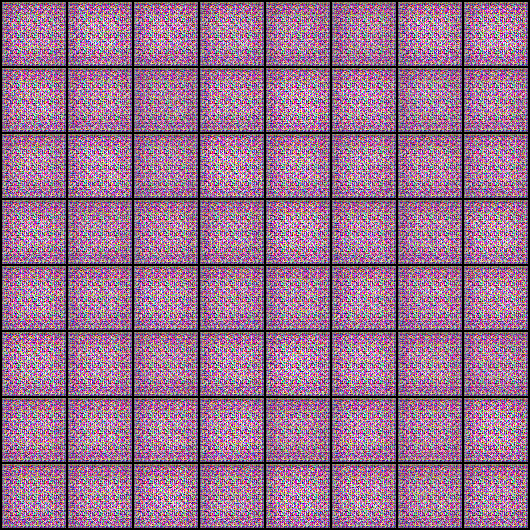

In [74]:
Image('./generated/generated-images-0001.png')

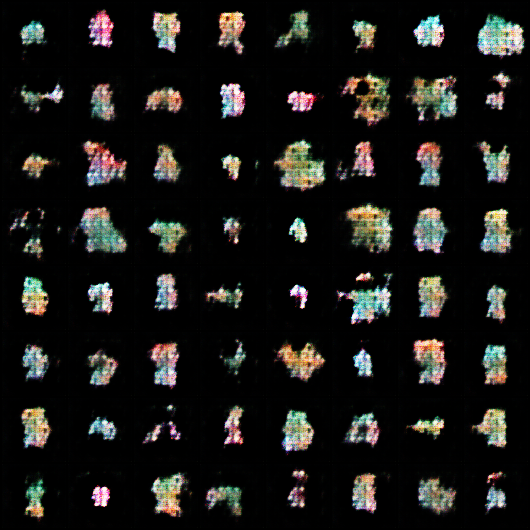

In [75]:
Image('./generated/generated-images-0050.png')

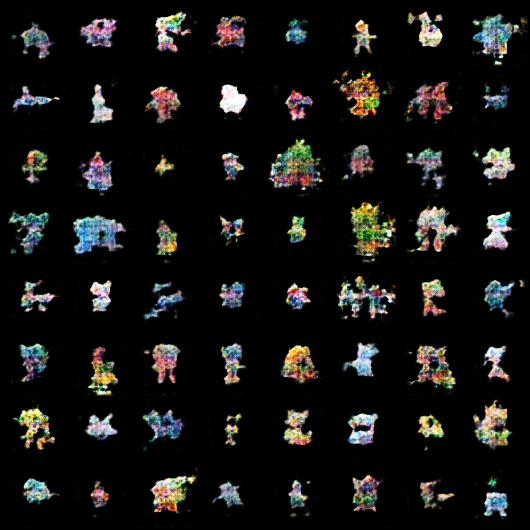

In [76]:
Image('./generated/generated-images-0100.png')

## Training Progress Visualization:
Losses and scores of the discriminator and generator over epochs are plotted.

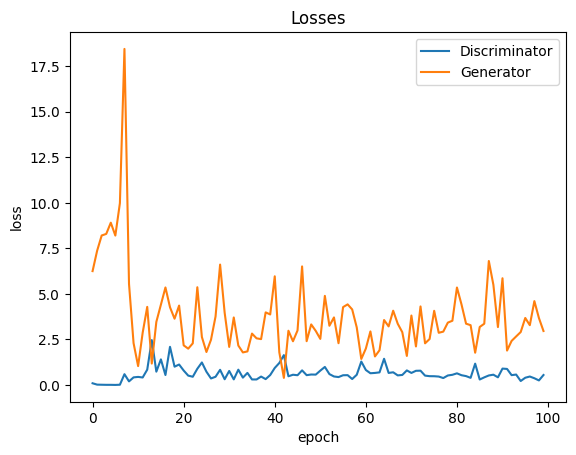

In [77]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

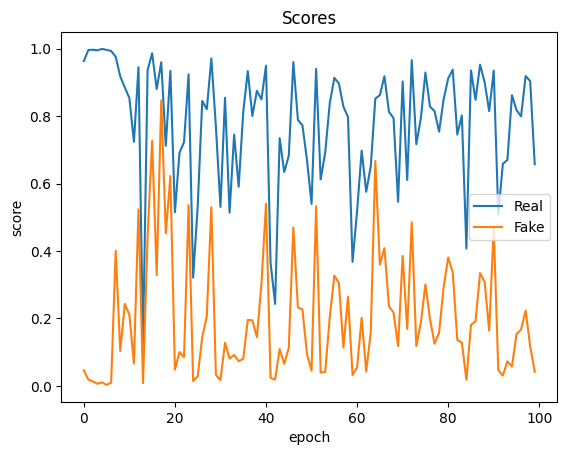

In [78]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# Results and Further Improvement


The results of the trained GAN model are visualized through generated image samples and loss/score plots. While the generated images show some resemblance to Pokémon character, further improvement can be achieved by training the model for more epochs or adjusting hyperparameters such as learning rate and network architecture.

By training the model for a longer duration or experimenting with different hyperparameters, the GAN can potentially generate more realistic and diverse Pokémon images, capturing finer details and characteristics of different Pokémon species.